This notebook is to establish the baseline for the project. Here I used the data from paper (Heng, Yujing J., et al). For survival analysis, both KaplanMeier and Cox Proportional Hazards (CoxPH) were implemented. In doing so, I could assess the prognostic accuracy of baseline linear Cox models generated using manual histologic features.

Heng, Yujing J., et al. "The molecular basis of breast cancer pathological phenotypes." The Journal of pathology 241.3 (2017): 375-391.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import lifelines as ll
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'lifelines'

In [3]:
morph = pd.read_csv('Morphologic consensus.csv')

In [4]:
outcome = pd.read_excel('base_info.xlsx')

In [5]:
outcome.set_index('case_id', inplace=True)

In [6]:
bind = outcome.merge(morph, left_index=True, right_on='sample')

In [7]:
len(bind)

846

In [8]:
len(morph)

850

In [9]:
set(morph['sample'].tolist()) - set(bind['sample'].tolist())

{'TCGA-A2-A0D2', 'TCGA-AN-A04D', 'TCGA-AQ-A1H2', 'TCGA-AQ-A1H3'}

In [10]:
bind['duration'] = bind['days_to_last_follow_up']

In [11]:
bind.loc[pd.notna(bind['days_to_death']).tolist(), 'duration'] = bind.loc[pd.notna(bind['days_to_death']).tolist(), 'days_to_death']

In [12]:
bind.loc[np.isnan(bind['duration'])] # have checked in TCGA, data lack comfirmed

,gender,updated_datetime,year_of_birth,age_at_diagnosis,days_to_death,days_to_last_follow_up,sample,epi_area,inflam,lcis,...,dcis,epi_tube,lymp,necrosis,nuc_pleo,fib_focus,mitosis,gene_exp,hist_type,duration
846,female,2018-09-06T13:49:20.245333-05:00,NaN,NaN,NaN,NaN,TCGA-OL-A66H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unc.edu.428ca7a1-6f08-4426-8f2d-28939166df70.2...,Other,NaN


In [13]:
bind.drop(846, inplace=True)

In [14]:
bind['observed'] = pd.notna(bind['days_to_death']).tolist()

In [15]:
target_raw = bind[(bind['duration'] != 0) & (bind['gender'] == 'female')]

In [16]:
target_raw.to_excel('bind.xlsx')

In [17]:
temp = target_raw.drop(['updated_datetime', 'year_of_birth', 'days_to_death', 'days_to_last_follow_up', 'gene_exp'], axis=1)

In [18]:
temp_drop = temp.dropna()

In [19]:
len(temp_drop)

760

In [20]:
temp_drop.to_excel('Hist.xlsx')

In [21]:
target = temp_drop.loc[:,['duration', 'observed']]
target.to_excel('Target.xlsx')

In [22]:
temp_drop.isna().sum()

gender              0
age_at_diagnosis    0
sample              0
epi_area            0
inflam              0
lcis                0
apo_feat            0
dcis                0
epi_tube            0
lymp                0
necrosis            0
nuc_pleo            0
fib_focus           0
mitosis             0
hist_type           0
duration            0
observed            0
dtype: int64

temp_drop.to_excel('temp_drop.xlsx')

In [23]:
T = temp_drop["duration"]
E = temp_drop["observed"]
kmf = ll.KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 760 observations, 642 censored>

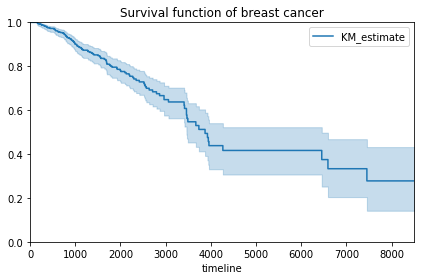

In [24]:
kmf.plot()
plt.ylim(0, 1);
plt.xlim(0, 8500);
plt.title('Survival function of breast cancer');
plt.tight_layout()
plt.savefig('km.png', dpi=300)

In [25]:
temp_drop.columns

Index(['gender', 'age_at_diagnosis', 'sample', 'epi_area', 'inflam', 'lcis',
       'apo_feat', 'dcis', 'epi_tube', 'lymp', 'necrosis', 'nuc_pleo',
       'fib_focus', 'mitosis', 'hist_type', 'duration', 'observed'],
      dtype='object')

In [26]:
dummy = pd.get_dummies(temp_drop.loc[:, 'epi_area': 'observed'], drop_first=True)

In [27]:
ages = temp_drop['age_at_diagnosis'].values
ages_min = min(ages)
dummy[ 'age_at_diagnosis'] = (ages - ages_min) / (max(ages) - ages_min)

In [28]:
dummy.head()

,duration,observed,epi_area_<25% (Low),epi_area_>75% (High),inflam_Present,lcis_Present,apo_feat_6-50% (Moderate),apo_feat_>50% (Marked),apo_feat_Absent,dcis_Present,...,necrosis_Present,nuc_pleo_Moderate to Marked Variation in Size,nuc_pleo_Small Regular Nuclei,fib_focus_Multiple Fibrotic Foci,mitosis_6-10 per 10 HPF (Medium),mitosis_>10 per 10 HPF (High),hist_type_Invasive Lobular Carcinoma,hist_type_Mixed,hist_type_Other,age_at_diagnosis
172,243.0,False,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0.746439
21,1099.0,False,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0.424199
401,2197.0,False,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.434300
334,991.0,True,0,1,1,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0.358629
455,1121.0,False,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0.475395


(172, duration                                              243
observed                                            False
epi_area_<25% (Low)                                     0
epi_area_>75% (High)                                    1
inflam_Present                                          0
lcis_Present                                            0
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  0
apo_feat_Absent                                         1
dcis_Present                                            0
epi_tube_<10% (poorly Differentiated                    1
epi_tube_>75% (Well Differentiated                      0
lymp_Present                                            0
necrosis_Present                                        0
nuc_pleo_Moderate to Marked Variation in Size           0
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci                        1
mitosis_

Name: 35, dtype: object)
(213, duration                                               31
observed                                            False
epi_area_<25% (Low)                                     0
epi_area_>75% (High)                                    0
inflam_Present                                          1
lcis_Present                                            0
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  0
apo_feat_Absent                                         1
dcis_Present                                            0
epi_tube_<10% (poorly Differentiated                    1
epi_tube_>75% (Well Differentiated                      0
lymp_Present                                            0
necrosis_Present                                        0
nuc_pleo_Moderate to Marked Variation in Size           1
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci         

Name: 489, dtype: object)
(82, duration                                             1847
observed                                            False
epi_area_<25% (Low)                                     0
epi_area_>75% (High)                                    0
inflam_Present                                          0
lcis_Present                                            0
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  0
apo_feat_Absent                                         1
dcis_Present                                            1
epi_tube_<10% (poorly Differentiated                    1
epi_tube_>75% (Well Differentiated                      0
lymp_Present                                            1
necrosis_Present                                        0
nuc_pleo_Moderate to Marked Variation in Size           1
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci         

Name: 600, dtype: object)
(363, duration                                             5739
observed                                            False
epi_area_<25% (Low)                                     0
epi_area_>75% (High)                                    0
inflam_Present                                          0
lcis_Present                                            0
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  1
apo_feat_Absent                                         0
dcis_Present                                            1
epi_tube_<10% (poorly Differentiated                    1
epi_tube_>75% (Well Differentiated                      0
lymp_Present                                            1
necrosis_Present                                        0
nuc_pleo_Moderate to Marked Variation in Size           1
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci        

Name: 107, dtype: object)
(475, duration                                             1692
observed                                             True
epi_area_<25% (Low)                                     0
epi_area_>75% (High)                                    1
inflam_Present                                          0
lcis_Present                                            0
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  0
apo_feat_Absent                                         1
dcis_Present                                            1
epi_tube_<10% (poorly Differentiated                    1
epi_tube_>75% (Well Differentiated                      0
lymp_Present                                            1
necrosis_Present                                        0
nuc_pleo_Moderate to Marked Variation in Size           1
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci        

Name: 144, dtype: object)
(590, duration                                              447
observed                                            False
epi_area_<25% (Low)                                     1
epi_area_>75% (High)                                    0
inflam_Present                                          0
lcis_Present                                            1
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  0
apo_feat_Absent                                         1
dcis_Present                                            1
epi_tube_<10% (poorly Differentiated                    0
epi_tube_>75% (Well Differentiated                      1
lymp_Present                                            0
necrosis_Present                                        1
nuc_pleo_Moderate to Marked Variation in Size           0
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci        

Name: 459, dtype: object)
(599, duration                                              522
observed                                            False
epi_area_<25% (Low)                                     0
epi_area_>75% (High)                                    0
inflam_Present                                          0
lcis_Present                                            0
apo_feat_6-50% (Moderate)                               0
apo_feat_>50% (Marked)                                  0
apo_feat_Absent                                         1
dcis_Present                                            1
epi_tube_<10% (poorly Differentiated                    1
epi_tube_>75% (Well Differentiated                      0
lymp_Present                                            0
necrosis_Present                                        1
nuc_pleo_Moderate to Marked Variation in Size           1
nuc_pleo_Small Regular Nuclei                           0
fib_focus_Multiple Fibrotic Foci        

In [29]:
dummy.to_excel('dummy.xlsx')

In [33]:
cph = ll.CoxPHFitter()
cph.fit(dummy, duration_col='duration', event_col='observed', show_progress=True)

Iteration 1: norm_delta = 1.00336, step_size = 0.95000, ll = -628.86816, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.18573, step_size = 0.95000, ll = -592.70237, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.01806, step_size = 0.95000, ll = -589.53593, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00126, step_size = 0.95000, ll = -589.48491, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00006, step_size = 0.95000, ll = -589.48467, seconds_since_start = 0.2
Iteration 6: norm_delta = 0.00000, step_size = 0.95000, ll = -589.48467, seconds_since_start = 0.2
Convergence completed after 6 iterations.


<lifelines.CoxPHFitter: fitted with 760 observations, 642 censored>

In [30]:
cph.print_summary()

n=760, number of events=118

                                                 coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
epi_area_<25% (Low)                            0.6341     1.8853    0.3137  2.0214 0.0432      0.0193      1.2489    *
epi_area_>75% (High)                          -0.1544     0.8569    0.2441 -0.6325 0.5271     -0.6329      0.3241     
inflam_Present                                -0.8845     0.4129    0.2511 -3.5219 0.0004     -1.3768     -0.3923  ***
lcis_Present                                  -0.0568     0.9448    0.4493 -0.1265 0.8993     -0.9375      0.8238     
apo_feat_6-50% (Moderate)                     -0.3952     0.6735    0.7658 -0.5161 0.6058     -1.8961      1.1057     
apo_feat_>50% (Marked)                         1.0163     2.7631    0.6448  1.5763 0.1150     -0.2474      2.2801     
apo_feat_Absent                                0.2514     1.2858    0.6170  0.4074 0.6837     -0.9579      1.4607     
dcis_Present       

In [31]:
cph.summary

,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
epi_area_<25% (Low),0.634107,1.885337,0.313691,2.021434,4.323487e-02,0.019283,1.248931
epi_area_>75% (High),-0.154420,0.856912,0.244144,-0.632496,5.270631e-01,-0.632935,0.324094
inflam_Present,-0.884531,0.412908,0.251148,-3.521944,4.283940e-04,-1.376773,-0.392289
lcis_Present,-0.056833,0.944752,0.449327,-0.126485,8.993481e-01,-0.937497,0.823831
apo_feat_6-50% (Moderate),-0.395219,0.673533,0.765795,-0.516090,6.057916e-01,-1.896149,1.105711
apo_feat_>50% (Marked),1.016347,2.763082,0.644782,1.576264,1.149650e-01,-0.247403,2.280097
apo_feat_Absent,0.251366,1.285781,0.617008,0.407395,6.837181e-01,-0.957948,1.460680
dcis_Present,-0.468638,0.625854,0.219192,-2.138026,3.251460e-02,-0.898245,-0.039030
epi_tube_<10% (poorly Differentiated,-0.043374,0.957553,0.258153,-0.168017,8.665701e-01,-0.549344,0.462596
epi_tube_>75% (Well Differentiated,-0.710352,0.491471,0.401092,-1.771046,7.655300e-02,-1.496478,0.075773


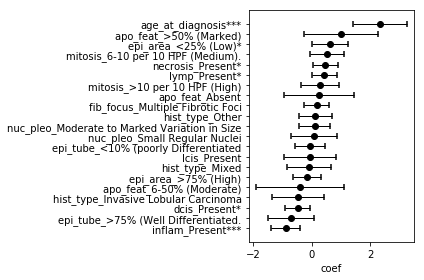

In [32]:
f, ax = plt.subplots()
cph.plot(ax=ax)
plt.tight_layout()
plt.savefig('cph.png', dpi=300)

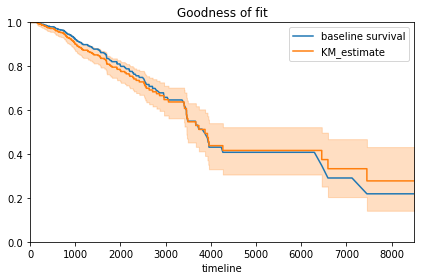

In [33]:
_, ax = plt.subplots()
plt.ylim(0, 1);
plt.xlim(0, 8500);
cph.baseline_survival_.plot(ax=ax)
kmf.plot(ax=ax)
ax.set_title('Goodness of fit')
plt.tight_layout()
plt.savefig('Goodness of fit.png', dpi=300)

In [34]:
from lifelines.utils import k_fold_cross_validation

In [35]:
cph = ll.CoxPHFitter()
scores = k_fold_cross_validation(cph, dummy, 'duration', event_col='observed', k=5)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.742756183745583, 0.6779783393501805, 0.7376267143709004, 0.6556156968876861, 0.7408637873754153]
0.710968144345953
0.03678893570102781


In [36]:
file_num = [1062, 846, 760, 642]
pie_num = [file_num[i] - file_num[i+1] if i < len(file_num) - 1 else file_num[i] for i in range(len(file_num))]

In [37]:
pie_name = ['Out of the paper', 'Gender male or data deficit', 'Event observed', 'Censored']

In [38]:
pct = [str(pie_num[i]) + ' ' + pie_name[i] for i in range(len(pie_name))]

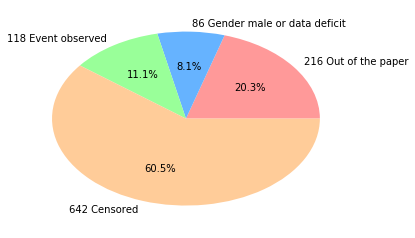

In [39]:
plt.figure()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(pie_num, labels=pct, colors=colors, autopct='%1.1f%%');
plt.savefig('file_num.png', dpi=300)

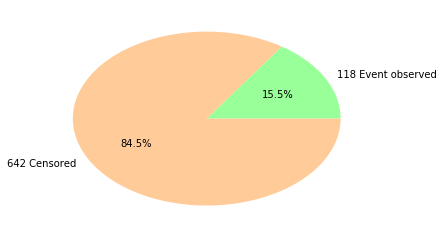

In [40]:
plt.figure()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(pie_num[-2:], labels=pct[-2:], colors=colors[-2:], autopct='%1.1f%%');
plt.savefig('data_num.png', dpi=300)

The age feature is quite interesting. I'd like to dig deeper to see if there are any patterns.

In [41]:
print(temp_drop['age_at_diagnosis'].min() / 365, '\n',
temp_drop['age_at_diagnosis'].max() / 365)

26.59178082191781 
 90.06027397260274


In [42]:
death = temp_drop.loc[temp_drop['observed'] == True]

In [43]:
print('death', '\n',
    death['age_at_diagnosis'].min(), '\t', death['age_at_diagnosis'].min() / 365, '\n',
death['age_at_diagnosis'].max(), '\t', death['age_at_diagnosis'].max() / 365)

death 
 9706.0 	 26.59178082191781 
 32872.0 	 90.06027397260274


In [44]:
censor = temp_drop.loc[temp_drop['observed'] == False]
print('censored', '\n',
    censor['age_at_diagnosis'].min(), '\t', censor['age_at_diagnosis'].min() / 365, '\n',
censor['age_at_diagnosis'].max(), '\t', censor['age_at_diagnosis'].max() / 365)

censored 
 9840.0 	 26.958904109589042 
 32872.0 	 90.06027397260274


In [45]:
temp_drop['age_at_diagnosis'].value_counts()

32872.0    6
23021.0    2
22199.0    2
24315.0    2
19415.0    2
29529.0    2
21910.0    2
18741.0    2
21628.0    2
21428.0    2
21479.0    2
14122.0    2
22798.0    2
14920.0    2
16736.0    2
19117.0    1
22703.0    1
26278.0    1
26988.0    1
19266.0    1
18594.0    1
18759.0    1
19836.0    1
29858.0    1
26548.0    1
24719.0    1
29115.0    1
16533.0    1
17346.0    1
28063.0    1
          ..
12525.0    1
23928.0    1
13680.0    1
21520.0    1
22688.0    1
19478.0    1
25370.0    1
18482.0    1
19989.0    1
20053.0    1
23507.0    1
29751.0    1
25674.0    1
19563.0    1
15903.0    1
32404.0    1
31173.0    1
22878.0    1
17996.0    1
23742.0    1
20072.0    1
24017.0    1
20570.0    1
21464.0    1
19596.0    1
22497.0    1
22094.0    1
18936.0    1
20804.0    1
21856.0    1
Name: age_at_diagnosis, Length: 741, dtype: int64

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


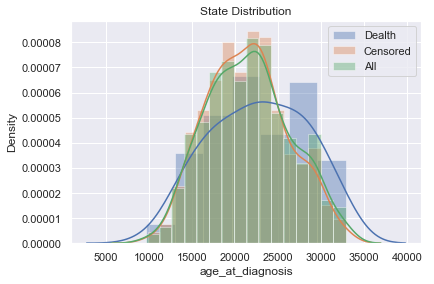

In [46]:
plt.figure()
sns.set()
sns.distplot(death['age_at_diagnosis'], label='Dealth');
sns.distplot(censor['age_at_diagnosis'], label='Censored');
sns.distplot(temp_drop['age_at_diagnosis'], label='All');
plt.legend()
plt.tight_layout()
plt.ylabel('Density')
plt.title('State Distribution');
plt.savefig('dis.png', dpi=300)